
WQI Class Distribution:
WQI_Class
Unsuitable    94
Poor          15
Good          10
Name: count, dtype: int64

Linear Regression (converted to classification) Performance:
Accuracy: 79.17%
Precision (macro): 0.4583
Recall (macro): 0.6140
F1 Score (macro): 0.4866
Specificity (macro): 0.9206

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         2
        Poor       0.38      1.00      0.55         3
  Unsuitable       1.00      0.84      0.91        19

    accuracy                           0.79        24
   macro avg       0.46      0.61      0.49        24
weighted avg       0.84      0.79      0.79        24


Confusion Matrix:
[[ 0  2  0]
 [ 0  3  0]
 [ 0  3 16]]


/tmp/ipython-input-1-4198234115.py:92: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

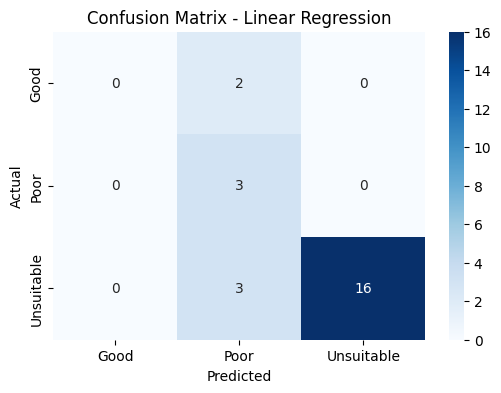

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Load your uploaded dataset
df = pd.read_csv("iot_water_data.csv")

# Rename columns if needed for consistency
df.rename(columns={
    'Oxygen Demand (BOD)': 'BOD',
}, inplace=True)

# Define the relevant columns
columns = ['pH', 'Dissolved Oxygen', 'BOD', 'Conductivity', 'Nitrate', 'Total Coliform']
df = df[columns]

# Handle missing values if any
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')
df.fillna(df.mean(), inplace=True)

# Define WQI standards and weights
standards = {
    'Dissolved Oxygen': (14.6, 6),
    'pH': (8.5, 7),
    'Conductivity': (300, 0),
    'BOD': (5, 0),
    'Nitrate': (45, 0),
    'Total Coliform': (1000, 0)
}
weights = {param: 1/std[0] for param, std in standards.items()}

# WQI calculation
def compute_qi(value, param):
    si, vid = standards[param]
    return ((value - vid) / (si - vid)) * 100 if pd.notna(value) else 0

df['WQI'] = df.apply(lambda row: sum(compute_qi(row[param], param) * weights[param]
                                     for param in standards.keys()) / sum(weights.values()), axis=1)

# WQI Class labeling
def classify_wqi(wqi):
    if wqi <= 50:
        return "Good"
    elif 51 <= wqi <= 100:
        return "Poor"
    else:
        return "Unsuitable"

df['WQI_Class'] = df['WQI'].apply(classify_wqi)

# Show class distribution
print("\nWQI Class Distribution:")
print(df['WQI_Class'].value_counts())

# Feature matrix (X) and target (y)
X = df[columns]
y = df['WQI_Class']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train Linear Regression model
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict and convert regression outputs to nearest class label
y_pred_cont = reg.predict(X_test)
y_pred = np.round(y_pred_cont).astype(int)

# Clip predictions to valid label range
y_pred = np.clip(y_pred, 0, len(le.classes_)-1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metric calculations
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Avoid divide-by-zero
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = (TP.sum()) / conf_matrix.sum()

# Replace nan with 0
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Macro averages
print("\nLinear Regression (converted to classification) Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Detailed sklearn report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix display
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Linear Regression')
plt.show()



Random Forest Performance (Manual Calculation):
Accuracy: 95.83%
Precision (macro): 0.9833
Recall (macro): 0.8333
F1 Score (macro): 0.8803
Specificity (macro): 0.9333

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       1.00      0.50      0.67         2
        Poor       1.00      1.00      1.00         3
  Unsuitable       0.95      1.00      0.97        19

    accuracy                           0.96        24
   macro avg       0.98      0.83      0.88        24
weighted avg       0.96      0.96      0.95        24



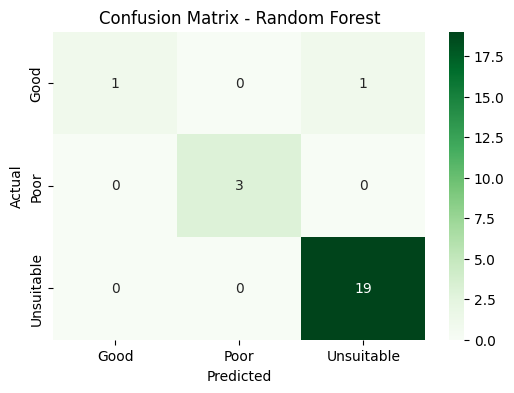

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Encode target again (if not already)
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metric calculations
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Metric formulas
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Print metrics
print("\nRandom Forest Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Sklearn report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


/tmp/ipython-input-3-1707963698.py:31: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


SVM Classifier Performance (Manual Calculation):
Accuracy: 79.17%
Precision (macro): 0.2639
Recall (macro): 0.3333
F1 Score (macro): 0.2946
Specificity (macro): 0.6667

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         2
        Poor       0.00      0.00      0.00         3
  Unsuitable       0.79      1.00      0.88        19

    accuracy                           0.79        24
   macro avg       0.26      0.33      0.29        24
weighted avg       0.63      0.79      0.70        24



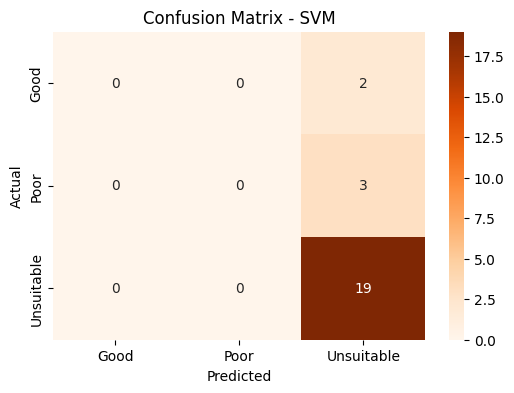

In [ ]:
from sklearn.svm import SVC

# Encode labels (if not already done)
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Features and target
X = df[columns]
y = y_encoded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM classifier
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# Predictions
y_pred = svm_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metrics
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Metric calculations
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Results
print("\nSVM Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Sklearn report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()



Decision Tree Classifier Performance (Manual Calculation):
Accuracy: 95.83%
Precision (macro): 0.9833
Recall (macro): 0.8889
F1 Score (macro): 0.9248
Specificity (macro): 0.9333

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       0.95      1.00      0.97        19

    accuracy                           0.96        24
   macro avg       0.98      0.89      0.92        24
weighted avg       0.96      0.96      0.95        24



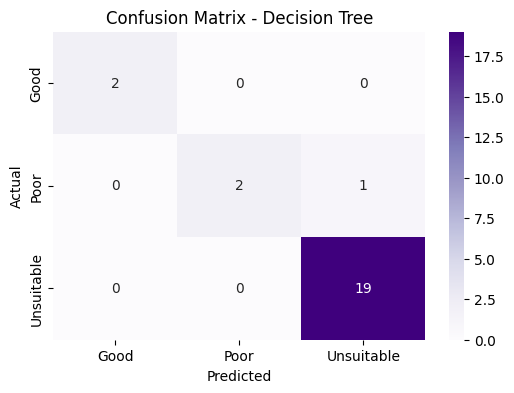

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Encode labels (if not already done)
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree model
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Predict
y_pred = dt_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metric calculations
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Calculate metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Print results
print("\nDecision Tree Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Sklearn report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()



Naive Bayes Classifier Performance (Manual Calculation):
Accuracy: 91.67%
Precision (macro): 0.8722
Recall (macro): 0.7222
F1 Score (macro): 0.7692
Specificity (macro): 0.9175

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       1.00      0.50      0.67         2
        Poor       0.67      0.67      0.67         3
  Unsuitable       0.95      1.00      0.97        19

    accuracy                           0.92        24
   macro avg       0.87      0.72      0.77        24
weighted avg       0.92      0.92      0.91        24



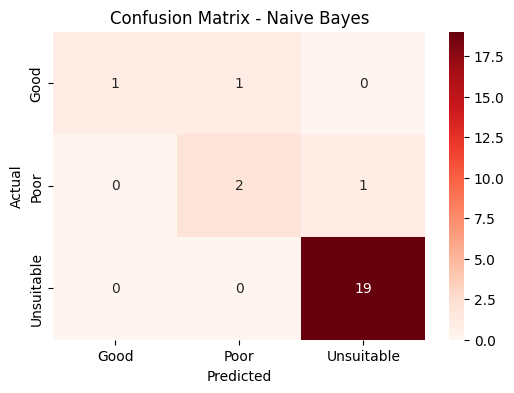

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Encode WQI class labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# Make predictions
y_pred = nb_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metrics
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Calculate evaluation metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle any nan values
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Output results
print("\nNaive Bayes Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Sklearn detailed report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classifier Performance (Manual Calculation):
Accuracy: 95.83%
Precision (macro): 0.9833
Recall (macro): 0.8889
F1 Score (macro): 0.9248
Specificity (macro): 0.9333

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       0.95      1.00      0.97        19

    accuracy                           0.96        24
   macro avg       0.98      0.89      0.92        24
weighted avg       0.96      0.96      0.95        24



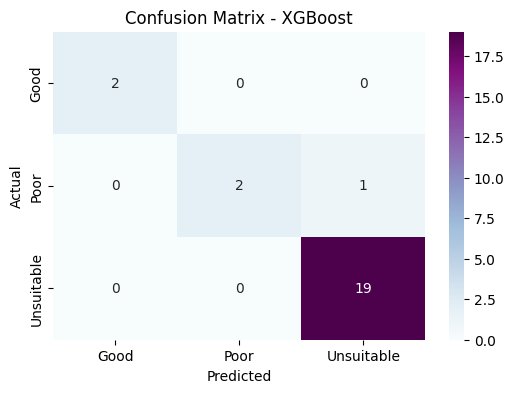

In [ ]:
from xgboost import XGBClassifier

# Encode WQI class labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metrics
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Calculate evaluation metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle nan values
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Output results
print("\nXGBoost Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Sklearn report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


/tmp/ipython-input-7-301840612.py:36: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _


K-Nearest Neighbors (KNN) Classifier Performance (Manual Calculation):
Accuracy: 83.33%
Precision (macro): 0.4667
Recall (macro): 0.5380
F1 Score (macro): 0.4982
Specificity (macro): 0.8349

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         2
        Poor       0.50      0.67      0.57         3
  Unsuitable       0.90      0.95      0.92        19

    accuracy                           0.83        24
   macro avg       0.47      0.54      0.50        24
weighted avg       0.78      0.83      0.80        24



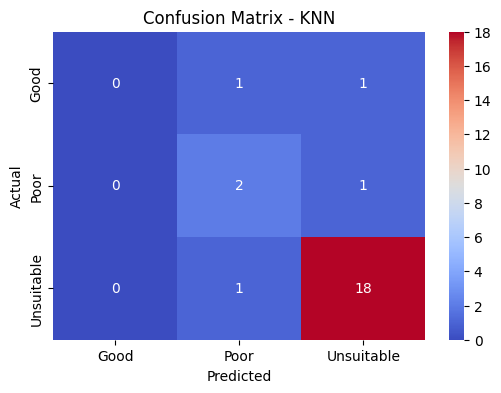

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Encode WQI class labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Scale features (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train KNN model
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predict
y_pred = knn_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metric calculations
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Calculate metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Output results
print("\nK-Nearest Neighbors (KNN) Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Sklearn report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipython-input-8-2453052773.py:35: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/py


Simple Neural Network (MLPClassifier) Performance (Manual Calculation):
Accuracy: 87.50%
Precision (macro): 0.4833
Recall (macro): 0.5556
F1 Score (macro): 0.5153
Specificity (macro): 0.9016

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         2
        Poor       0.50      0.67      0.57         3
  Unsuitable       0.95      1.00      0.97        19

    accuracy                           0.88        24
   macro avg       0.48      0.56      0.52        24
weighted avg       0.81      0.88      0.84        24



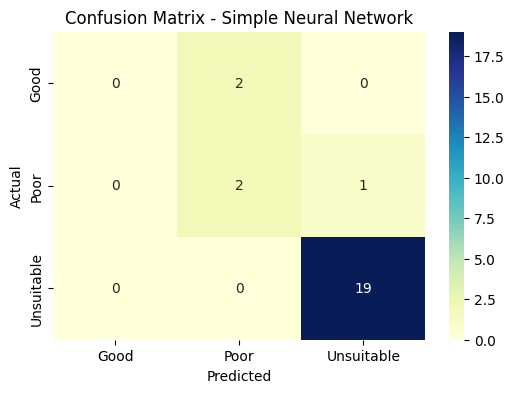

In [ ]:
from sklearn.neural_network import MLPClassifier

# Encode WQI class labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Scale the features (required for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train MLP (Simple Neural Network)
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_clf.fit(X_train, y_train)

# Predictions
y_pred = mlp_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metric calculations
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Calculate metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Print results
print("\nSimple Neural Network (MLPClassifier) Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Classification report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Simple Neural Network')
plt.show()


/tmp/ipython-input-9-1789340680.py:36: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  


Logistic Regression Classifier Performance (Manual Calculation):
Accuracy: 87.50%
Precision (macro): 0.4833
Recall (macro): 0.5556
F1 Score (macro): 0.5153
Specificity (macro): 0.9016

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         2
        Poor       0.50      0.67      0.57         3
  Unsuitable       0.95      1.00      0.97        19

    accuracy                           0.88        24
   macro avg       0.48      0.56      0.52        24
weighted avg       0.81      0.88      0.84        24



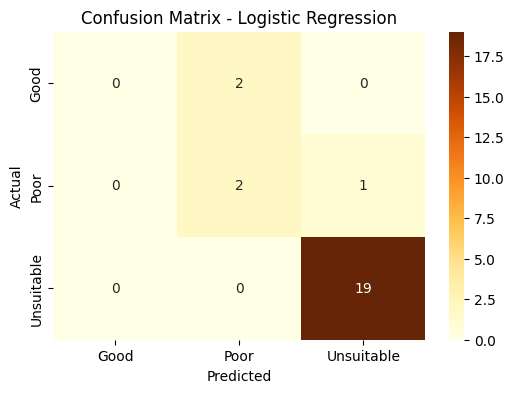

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Encode WQI class labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# Define features and target
X = df[columns]
y = y_encoded

# Scale features (recommended for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train, y_train)

# Predictions
y_pred = lr_clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Manual metric calculations
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# Metrics calculation
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Print results
print("\nLogistic Regression Classifier Performance (Manual Calculation):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# Classification report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


ENSEMBLING


Bagging - Decision Tree Performance:
Accuracy: 95.83%
Precision (macro): 0.8889
Recall (macro): 0.8889
F1 Score (macro): 0.8667
Specificity (macro): 0.9848

Classification Report:
              precision    recall  f1-score   support

        Good       0.67      1.00      0.80         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       1.00      1.00      1.00        19

    accuracy                           0.96        24
   macro avg       0.89      0.89      0.87        24
weighted avg       0.97      0.96      0.96        24



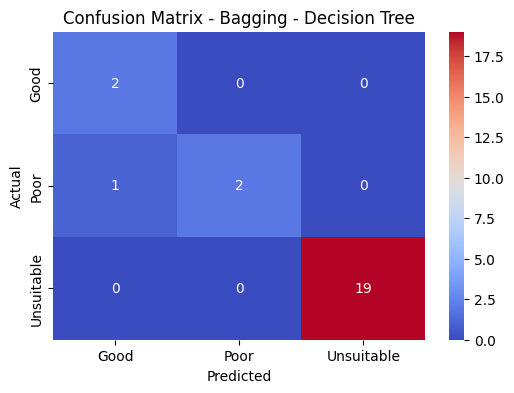


Bagging - Random Forest Performance:
Accuracy: 91.67%
Precision (macro): 0.9683
Recall (macro): 0.7222
F1 Score (macro): 0.8056
Specificity (macro): 0.8667

Classification Report:
              precision    recall  f1-score   support

        Good       1.00      0.50      0.67         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       0.90      1.00      0.95        19

    accuracy                           0.92        24
   macro avg       0.97      0.72      0.81        24
weighted avg       0.92      0.92      0.91        24



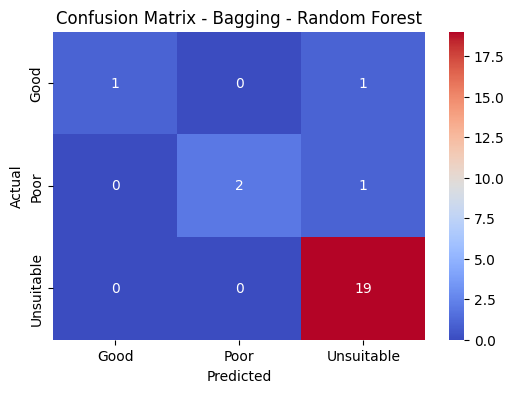

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Encode labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# --- Feature columns and scaling ---
X = df[columns]
y = y_encoded

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Bagging with Decision Tree ---
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    random_state=42
)
bag_dt.fit(X_train, y_train)
y_pred_dt = bag_dt.predict(X_test)

# --- Bagging with Random Forest ---
bag_rf = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_estimators=10,
    random_state=42
)
bag_rf.fit(X_train, y_train)
y_pred_rf = bag_rf.predict(X_test)

# --- Evaluation Function ---
def evaluate_model(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)
    accuracy = TP.sum() / conf_matrix.sum()

    # Handle NaNs
    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1 = np.nan_to_num(f1)
    specificity = np.nan_to_num(specificity)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision (macro): {precision.mean():.4f}")
    print(f"Recall (macro): {recall.mean():.4f}")
    print(f"F1 Score (macro): {f1.mean():.4f}")
    print(f"Specificity (macro): {specificity.mean():.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- Evaluate Models ---
evaluate_model(y_test, y_pred_dt, "Bagging - Decision Tree")
evaluate_model(y_test, y_pred_rf, "Bagging - Random Forest")



Bagging - Decision Tree Performance:
Accuracy: 95.83%
Precision (macro): 0.8889
Recall (macro): 0.8889
F1 Score (macro): 0.8667
Specificity (macro): 0.9848

Classification Report:
              precision    recall  f1-score   support

        Good       0.67      1.00      0.80         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       1.00      1.00      1.00        19

    accuracy                           0.96        24
   macro avg       0.89      0.89      0.87        24
weighted avg       0.97      0.96      0.96        24



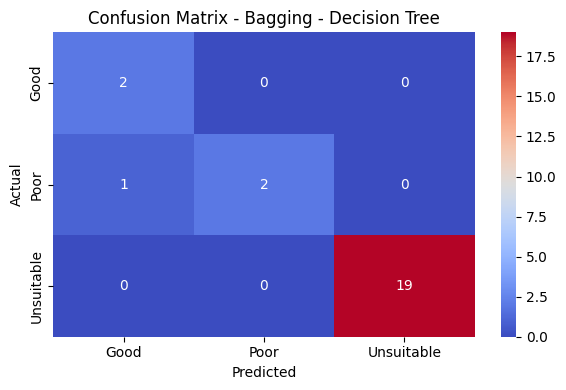

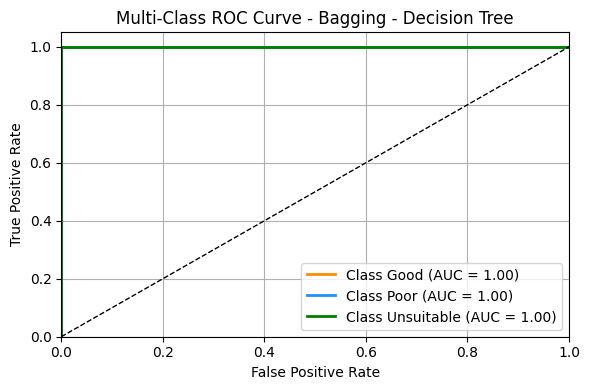


Bagging - Random Forest Performance:
Accuracy: 91.67%
Precision (macro): 0.9683
Recall (macro): 0.7222
F1 Score (macro): 0.8056
Specificity (macro): 0.8667

Classification Report:
              precision    recall  f1-score   support

        Good       1.00      0.50      0.67         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       0.90      1.00      0.95        19

    accuracy                           0.92        24
   macro avg       0.97      0.72      0.81        24
weighted avg       0.92      0.92      0.91        24



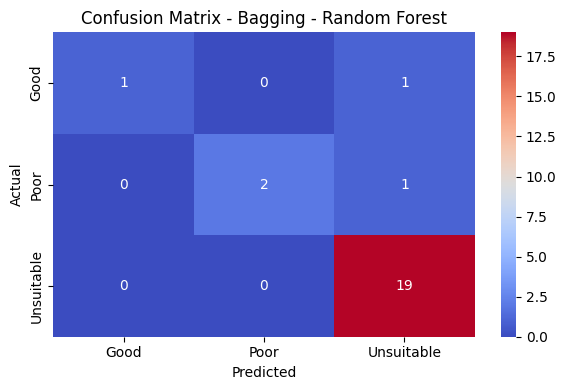

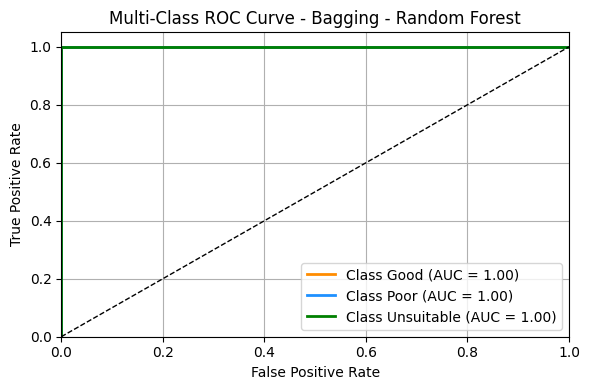

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Encode labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(df['WQI_Class'])

# --- Feature columns and scaling ---
X = df[columns]
y = y_encoded

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Bagging with Decision Tree ---
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    random_state=42
)
bag_dt.fit(X_train, y_train)
y_pred_dt = bag_dt.predict(X_test)
y_proba_dt = bag_dt.predict_proba(X_test)

# --- Bagging with Random Forest ---
bag_rf = BaggingClassifier(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_estimators=10,
    random_state=42
)
bag_rf.fit(X_train, y_train)
y_pred_rf = bag_rf.predict(X_test)
y_proba_rf = bag_rf.predict_proba(X_test)

# --- Evaluation Function with ROC ---
def evaluate_model(y_test, y_pred, y_proba, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    specificity = TN / (TN + FP)
    accuracy = TP.sum() / conf_matrix.sum()

    # Handle NaNs
    precision = np.nan_to_num(precision)
    recall = np.nan_to_num(recall)
    f1 = np.nan_to_num(f1)
    specificity = np.nan_to_num(specificity)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision (macro): {precision.mean():.4f}")
    print(f"Recall (macro): {recall.mean():.4f}")
    print(f"F1 Score (macro): {f1.mean():.4f}")
    print(f"Specificity (macro): {specificity.mean():.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve Plot
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    n_classes = y_test_bin.shape[1]

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 4))
    colors = ['darkorange', 'dodgerblue', 'green', 'red', 'purple', 'brown']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Evaluate Models with ROC ---
evaluate_model(y_test, y_pred_dt, y_proba_dt, "Bagging - Decision Tree")
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Bagging - Random Forest")



📊 AdaBoost Classifier with 5-Fold Cross-Validation
Accuracy: 93.28%
Precision (Macro Avg): 0.8723
Recall (Macro Avg): 0.8187
F1 Score (Macro Avg): 0.8434
Specificity (Macro Avg): 0.9340


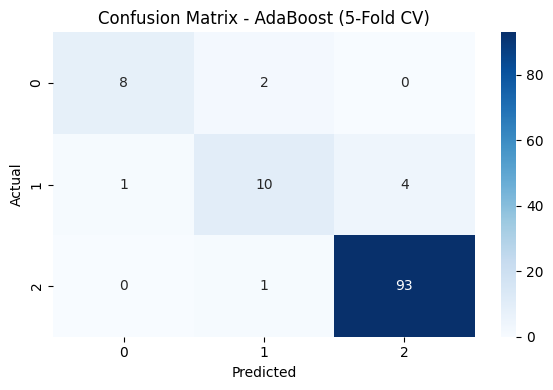

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(n_estimators=150, learning_rate=0.7, random_state=42)

# Get class labels
class_labels = np.unique(y)
class_names = [str(cls) for cls in class_labels]

# Initialize total confusion matrix
total_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)

# Cross-validation loop
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    total_cm += cm

# Manual metric calculations
TP = np.diag(total_cm)
FP = total_cm.sum(axis=0) - TP
FN = total_cm.sum(axis=1) - TP
TN = total_cm.sum() - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / total_cm.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Print results
print("\n📊 AdaBoost Classifier with 5-Fold Cross-Validation")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro Avg): {precision.mean():.4f}")
print(f"Recall (Macro Avg): {recall.mean():.4f}")
print(f"F1 Score (Macro Avg): {f1.mean():.4f}")
print(f"Specificity (Macro Avg): {specificity.mean():.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - AdaBoost (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



📊 AdaBoost Classifier with 5-Fold Cross-Validation
Accuracy: 93.28%
Precision (Macro Avg): 0.8723
Recall (Macro Avg): 0.8187
F1 Score (Macro Avg): 0.8434
Specificity (Macro Avg): 0.9340


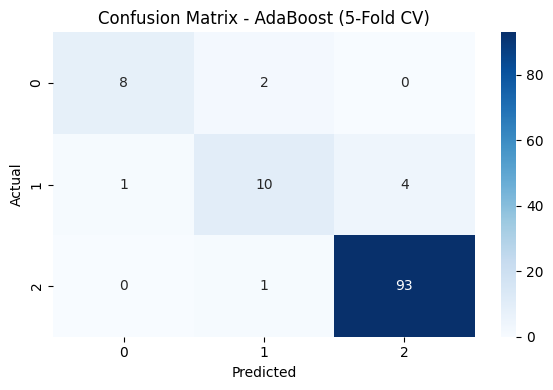

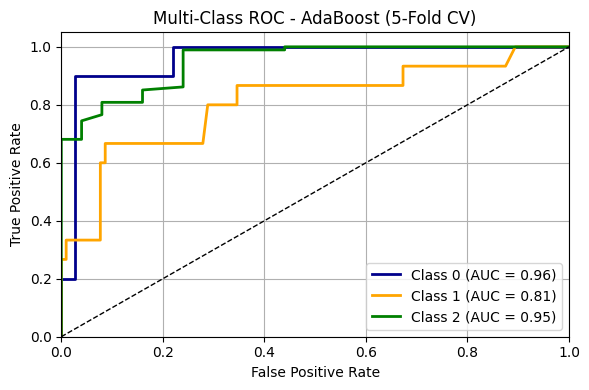

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = AdaBoostClassifier(n_estimators=150, learning_rate=0.7, random_state=42)

# ✅ Get class labels
class_labels = np.unique(y)
class_names = [str(cls) for cls in class_labels]

# ✅ Initialize confusion matrix and ROC data
total_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)
y_test_all = []
y_score_all = []

# ✅ Cross-validation loop
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Confusion matrix accumulation
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    total_cm += cm

    # Store for ROC curve
    y_test_all.extend(y_test)
    y_score_all.extend(y_proba)

# ✅ Manual metric calculations
TP = np.diag(total_cm)
FP = total_cm.sum(axis=0) - TP
FN = total_cm.sum(axis=1) - TP
TN = total_cm.sum() - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / total_cm.sum()

# ✅ Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# ✅ Print results
print("\n📊 AdaBoost Classifier with 5-Fold Cross-Validation")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro Avg): {precision.mean():.4f}")
print(f"Recall (Macro Avg): {recall.mean():.4f}")
print(f"F1 Score (Macro Avg): {f1.mean():.4f}")
print(f"Specificity (Macro Avg): {specificity.mean():.4f}")

# ✅ Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - AdaBoost (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ ROC Curve
# Binarize test labels
y_test_bin = label_binarize(y_test_all, classes=class_labels)
y_score_all = np.array(y_score_all)
n_classes = len(class_labels)

# Compute ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot ROC Curves
plt.figure(figsize=(6, 4))
colors = ['darkblue', 'orange', 'green']  # Customize as per your class count
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC - AdaBoost (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



📊 Gradient Boosting Classifier with 5-Fold Cross-Validation
Accuracy: 92.44%
Precision (Macro Avg): 0.9161
Recall (Macro Avg): 0.7965
F1 Score (Macro Avg): 0.8467
Specificity (Macro Avg): 0.9003


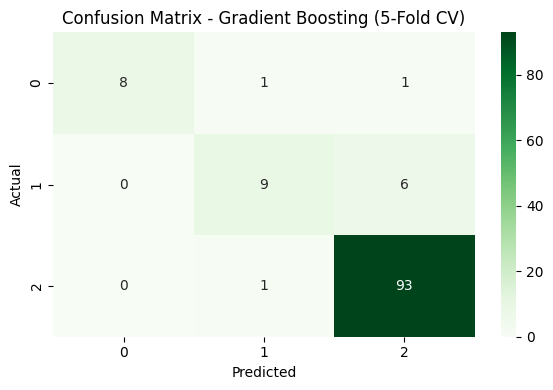

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=130, learning_rate=0.08, max_depth=5, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize total confusion matrix
total_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)

# Cross-validation loop
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    total_cm += cm

# Manual metric calculations
TP = np.diag(total_cm)
FP = total_cm.sum(axis=0) - TP
FN = total_cm.sum(axis=1) - TP
TN = total_cm.sum() - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / total_cm.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Print results
print("\n📊 Gradient Boosting Classifier with 5-Fold Cross-Validation")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro Avg): {precision.mean():.4f}")
print(f"Recall (Macro Avg): {recall.mean():.4f}")
print(f"F1 Score (Macro Avg): {f1.mean():.4f}")
print(f"Specificity (Macro Avg): {specificity.mean():.4f}")

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Gradient Boosting (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



📊 Gradient Boosting Classifier with 5-Fold Cross-Validation
Accuracy: 92.44%
Precision (Macro Avg): 0.9161
Recall (Macro Avg): 0.7965
F1 Score (Macro Avg): 0.8467
Specificity (Macro Avg): 0.9003


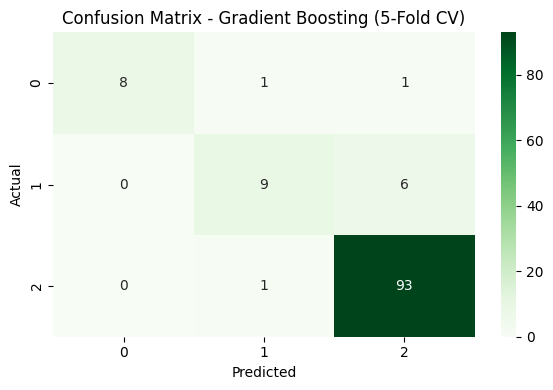

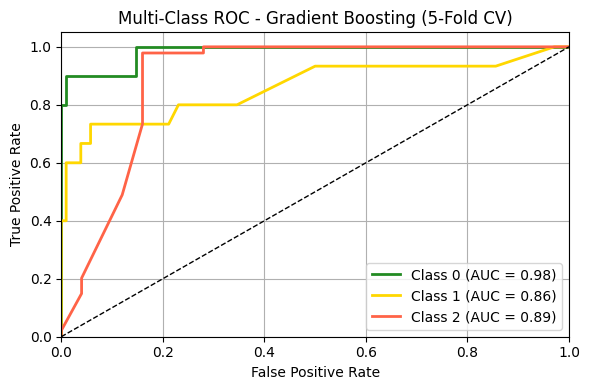

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=130,
    learning_rate=0.08,
    max_depth=5,
    random_state=42
)

# ✅ Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
total_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)

# ✅ Initialize for ROC
y_test_all = []
y_score_all = []

# ✅ Cross-validation loop
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    y_proba = gb_model.predict_proba(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    total_cm += cm

    # ✅ Store scores for ROC
    y_test_all.extend(y_test)
    y_score_all.extend(y_proba)

# ✅ Metric calculations
TP = np.diag(total_cm)
FP = total_cm.sum(axis=0) - TP
FN = total_cm.sum(axis=1) - TP
TN = total_cm.sum() - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / total_cm.sum()

# ✅ Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# ✅ Display results
print("\n📊 Gradient Boosting Classifier with 5-Fold Cross-Validation")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro Avg): {precision.mean():.4f}")
print(f"Recall (Macro Avg): {recall.mean():.4f}")
print(f"F1 Score (Macro Avg): {f1.mean():.4f}")
print(f"Specificity (Macro Avg): {specificity.mean():.4f}")

# ✅ Confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Gradient Boosting (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ ROC Curve
# Binarize test labels
y_test_bin = label_binarize(y_test_all, classes=class_labels)
y_score_all = np.array(y_score_all)
n_classes = len(class_labels)

# ✅ Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot ROC curves
plt.figure(figsize=(6, 4))
colors = ['forestgreen', 'gold', 'tomato']  # Add/modify colors based on your class count
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC - Gradient Boosting (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


📊 XGBoost Classifier with 5-Fold Cross-Validation
Accuracy: 93.28%
Precision (Macro Avg): 0.9242
Recall (Macro Avg): 0.8187
F1 Score (Macro Avg): 0.8645
Specificity (Macro Avg): 0.9136


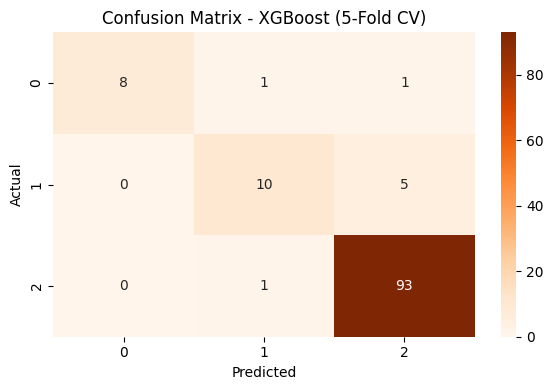

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define XGBoost model
xgb_model = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
total_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)

# Loop over folds
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    total_cm += cm

# Manual metric calculations
TP = np.diag(total_cm)
FP = total_cm.sum(axis=0) - TP
FN = total_cm.sum(axis=1) - TP
TN = total_cm.sum() - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / total_cm.sum()

# Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# Display results
print("\n📊 XGBoost Classifier with 5-Fold Cross-Validation")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro Avg): {precision.mean():.4f}")
print(f"Recall (Macro Avg): {recall.mean():.4f}")
print(f"F1 Score (Macro Avg): {f1.mean():.4f}")
print(f"Specificity (Macro Avg): {specificity.mean():.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - XGBoost (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


📊 XGBoost Classifier with 5-Fold Cross-Validation
Accuracy: 93.28%
Precision (Macro Avg): 0.9242
Recall (Macro Avg): 0.8187
F1 Score (Macro Avg): 0.8645
Specificity (Macro Avg): 0.9136


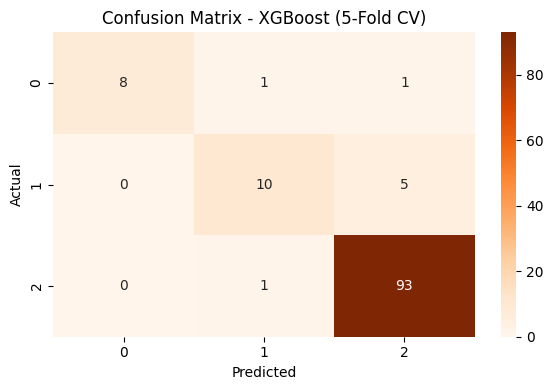

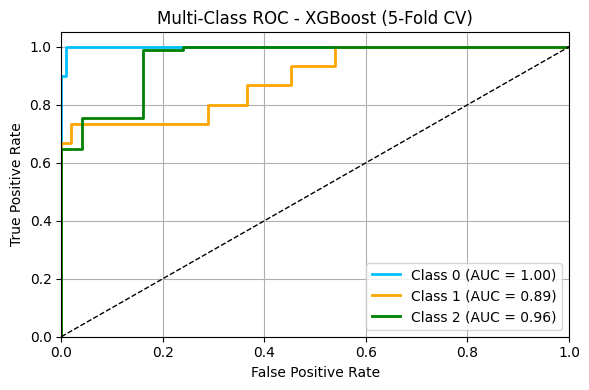

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Define model
xgb_model = XGBClassifier(
    n_estimators=120,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# ✅ Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
total_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)

# ✅ Initialize for ROC curve
y_test_all = []
y_score_all = []

# ✅ Loop through folds
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # ✅ Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    total_cm += cm

    # ✅ Collect scores for ROC
    y_test_all.extend(y_test)
    y_score_all.extend(xgb_model.predict_proba(X_test))

# ✅ Manual metric calculation
TP = np.diag(total_cm)
FP = total_cm.sum(axis=0) - TP
FN = total_cm.sum(axis=1) - TP
TN = total_cm.sum() - (TP + FP + FN)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / total_cm.sum()

# ✅ Handle NaNs
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# ✅ Display metrics
print("\n📊 XGBoost Classifier with 5-Fold Cross-Validation")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro Avg): {precision.mean():.4f}")
print(f"Recall (Macro Avg): {recall.mean():.4f}")
print(f"F1 Score (Macro Avg): {f1.mean():.4f}")
print(f"Specificity (Macro Avg): {specificity.mean():.4f}")

# ✅ Confusion Matrix Plot
plt.figure(figsize=(6, 4))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - XGBoost (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ ROC Curve
# Binarize y_test
y_test_bin = label_binarize(y_test_all, classes=class_labels)
y_score_all = np.array(y_score_all)
n_classes = len(class_labels)

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot ROC curves
plt.figure(figsize=(6, 4))
colors = ['deepskyblue', 'orange', 'green']  # Extend if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC - XGBoost (5-Fold CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:00:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:00:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:00:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Stacking Classifier Results (DT + SVM + XGBoost with 5-Fold CV):
Accuracy: 95.65%
Precision (macro): 0.9825
Recall (macro): 0.8889
F1 Score (macro): 0.9243
Specificity (macro): 0.9333

Classification Report (sklearn):
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00         2
        Poor       1.00      0.67      0.80         3
  Unsuitable       0.95      1.00      0.97        18

    accuracy                           0.96        23
   macro avg       0.98      0.89      0.92        23
weighted avg       0.96      0.96      0.95        23



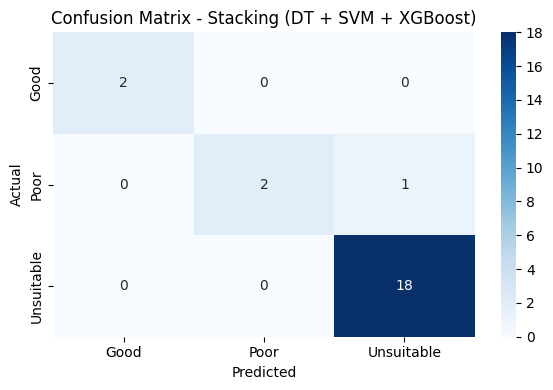

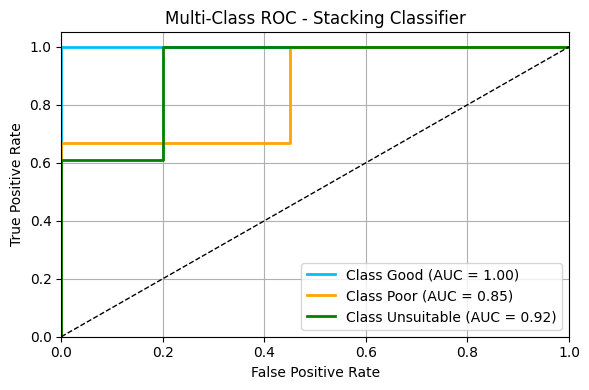

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Base learners: Decision Tree, SVM, and XGBoost
base_learners = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

# ✅ Meta learner
meta_model = LogisticRegression(random_state=42)

# ✅ Stacking classifier with cross-validation
stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5)

# ✅ Fit the stacking model
stack_model.fit(X_train, y_train)

# ✅ Predict on test set
y_pred = stack_model.predict(X_test)

# ✅ Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (TP + FP + FN)

# ✅ Metric calculations
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
specificity = TN / (TN + FP)
accuracy = TP.sum() / conf_matrix.sum()

# ✅ Replace NaNs with zero
precision = np.nan_to_num(precision)
recall = np.nan_to_num(recall)
f1 = np.nan_to_num(f1)
specificity = np.nan_to_num(specificity)

# ✅ Display results
print("\n✅ Stacking Classifier Results (DT + SVM + XGBoost with 5-Fold CV):")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (macro): {precision.mean():.4f}")
print(f"Recall (macro): {recall.mean():.4f}")
print(f"F1 Score (macro): {f1.mean():.4f}")
print(f"Specificity (macro): {specificity.mean():.4f}")

# ✅ Classification report
print("\nClassification Report (sklearn):")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=1))

# ✅ Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacking (DT + SVM + XGBoost)')
plt.tight_layout()
plt.show()

# ✅ ROC Curve for Multi-class
# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = stack_model.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(6, 4))
colors = ['deepskyblue', 'orange', 'green']
class_names = le.classes_

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC - Stacking Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
